# Trivial Model Approach

Every Spacetime frame is passed to a pretrained Image Classifier (ResNet50), and its embedding is extracted. These embeddings are stacked along the temporal axis and fed into an LSTM. The output of a single LSTM cell is a 42 vector, which are again stacked along the temporal axis to create a cochleagram. Reconstruction loss is computed between the predicted cochleagram and the true cochleagram and the loss is backpropagated to train the network.

In [1]:
import sys

sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

from VISTorchUtils import VISDataset, VISLoss
from VISDataPoint import VISDataPoint
from utils import visCollate

In [2]:
trainDataset = VISDataset('/scratch/vis_data/train')
valDataset = VISDataset('/scratch/vis_data/test')

In [3]:
BATCH_SIZE=4

In [4]:
trainDataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, collate_fn=visCollate, shuffle=True, num_workers=6)
valDataLoader = DataLoader(valDataset, batch_size=BATCH_SIZE, collate_fn=visCollate, num_workers=6)

In [5]:
class VISTrivialModel(pl.LightningModule):

    def __init__(self, outputSize:int):
        super().__init__()
        self.featureExtractor = resnet18(ResNet18_Weights.DEFAULT)
        self.featureExtractor.fc = nn.Identity()

        for param in self.featureExtractor.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(512, 256, batch_first=True)
        self.fc = nn.Linear(256, outputSize)


    def forward(self, stFrames, frame0):

        # stFrames: batchx45x224x224x3
        # frame0: batchx224x224x3

        stFrameFeatures = []
        for i in range(stFrames.shape[1]):
            currStFrame = stFrames[:,i,:,:,:].squeeze(1)
            currStFrameFeatures = self.featureExtractor(currStFrame)
            stFrameFeatures.append(currStFrameFeatures)
        stFrameFeatures = torch.stack(stFrameFeatures, dim=1)

        frame0Features = self.featureExtractor(frame0).unsqueeze(1).repeat(1, stFrames.shape[1], 1)
        # X = torch.cat([stFrameFeatures, frame0Features], dim=2)
        X = stFrameFeatures
        
        X.detach_()
        # X is the input to the LSTM -> batchx45x1024
        X, _ = self.lstm(X)

        out = self.fc(X).transpose(1, 2)
        # # Pass the LSTM output of each timestep through a linear layer
        # out = []

        # for i in range(X.shape[1]):
        #     currOut = self.fc(X[:,i,:])
        #     out.append(currOut)
        
        # out = torch.stack(out, dim=1).transpose(1,2)
        
        return out
    
    def training_step(self, batch, batch_idx):
        coch, stFrames, frame0, material = batch
        out = self(stFrames, frame0)
        # loss = VISLoss()(out, coch)
        loss = nn.MSELoss()(out, coch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        coch, stFrames, frame0, material = batch
        out = self(stFrames, frame0)
        # loss = VISLoss()(out, coch)
        loss = nn.MSELoss()(out, coch)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [6]:
model = VISTrivialModel(outputSize=42)

/home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [7]:
logger = pl.loggers.TensorBoardLogger('tb_logs', name='trivial_model')

In [8]:
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=1, logger=logger)

/home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, trainDataLoader, valDataLoader)

/home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/aa_aanegola/miniconda3/envs/cv/lib/python3.9/ ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type   | Params
--------------------------------------------
0 | featureExtractor | ResNet | 11.2 M
1 | lstm             | LSTM   | 788 K 
2 | fc               | Linear | 10.8 K
--------------------------------------------
799 K     Trainable params
11.2 M    Non-trainable params
12.0 M    Total params
47.903    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 5030/5030 [20:46<00:00,  4.04it/s, v_num=10, train_loss_step=0.00657, val_loss_step=0.004, val_loss_epoch=0.00689, train_loss_epoch=0.00649]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 5030/5030 [20:47<00:00,  4.03it/s, v_num=10, train_loss_step=0.00657, val_loss_step=0.004, val_loss_epoch=0.00689, train_loss_epoch=0.00649]


In [10]:
from utils import waveFromCochleagram
import matplotlib.pyplot as plt

In [11]:
for _, batch in enumerate(trainDataLoader):
    coch, stFrames, frame0, material = batch
    coch_pred = model(stFrames, frame0)[0].detach().cpu()
    break
    plt.plot(range(len(coch_pred)), coch_pred)
    break
    

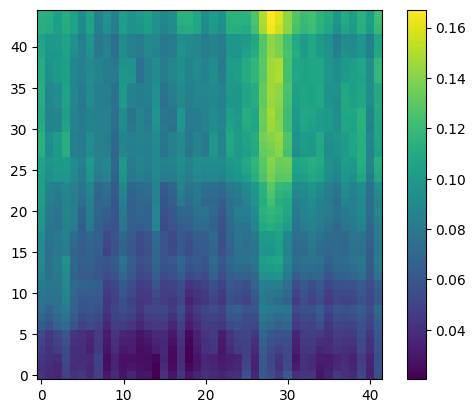

In [15]:
plt.imshow(coch_pred.T, origin='lower')
plt.colorbar()

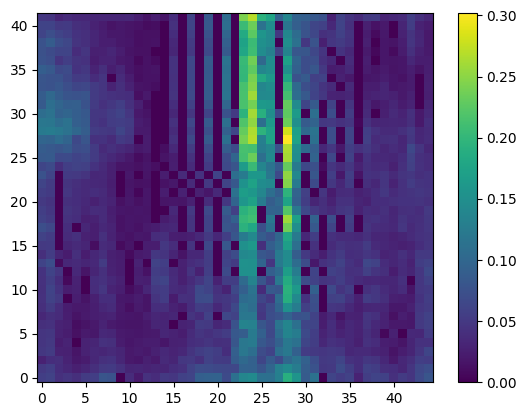

In [27]:
plt.imshow(coch[0], origin='lower')
plt.colorbar()

In [18]:
print(torch.norm(coch[0] - coch_pred))

tensor(2.4700)


In [19]:
wav = waveFromCochleagram(coch_pred.numpy())

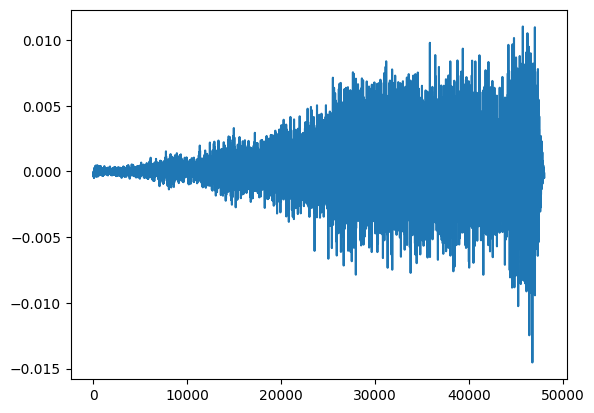

In [22]:
plt.plot(range(wav.shape[0]), wav)

In [25]:
wav_og = waveFromCochleagram(coch[0].numpy())

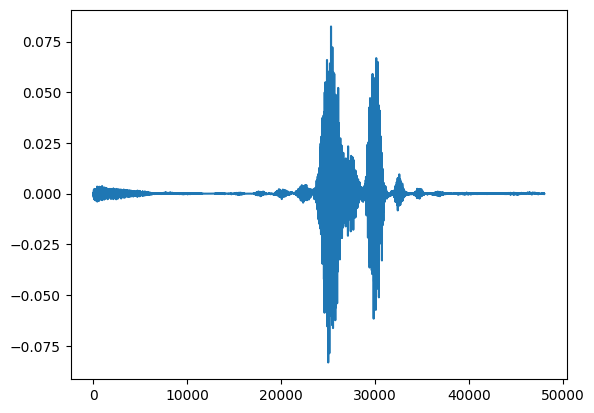

In [28]:
plt.plot(range(wav_og.shape[0]), wav_og)